In [1]:
'''%cd D:\uni\9 Spring 2023\Stat 535\yelp''' #this is just for my own working directory

D:\uni\9 Spring 2023\Stat 535\yelp


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
## Importing modules

import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [6]:
## Importing data
review_data = pd.read_csv('yelp_academic_dataset_review.csv', usecols= ['business_id', 'stars', 'review_id', 'user_id'])
business_data = pd.read_csv('yelp_academic_dataset_business.csv', usecols= ['business_id', 'name', 'review_count', 'categories', 'stars'])
user_data = pd.read_csv('yelp_academic_dataset_user.csv', usecols= ['user_id', 'name'])

## Since users and business dataframe both have the same column names we will update them accordingly
user_data = user_data.rename(columns = { 'name': 'Username' })
business_data = business_data.rename(columns = { 'name': 'Restaurant name' })

In [13]:
review_data

,review_id,user_id,business_id,stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0
...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0


In [7]:
print(user_data.columns.values)

['user_id' 'Username']


In [8]:
print(business_data.columns.values)

['business_id' 'categories' 'review_count' 'Restaurant name' 'stars']


In [9]:
print(review_data.columns.values)

['review_id' 'user_id' 'business_id' 'stars']


In [10]:
user_data.isnull().sum()


user_id     0
Username    8
dtype: int64

In [11]:
business_data.isnull().sum()


business_id          0
categories         103
review_count         0
Restaurant name      0
stars                0
dtype: int64

In [14]:
review_data.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
dtype: int64

In [15]:
business_data.head(5)

,business_id,categories,review_count,Restaurant name,stars
0,Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",7,"Abby Rappoport, LAC, CMQ",5.0
1,mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",15,The UPS Store,3.0
2,tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",22,Target,3.5
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,St Honore Pastries,4.0
4,mWMc6_wTdE0EUBKIGXDVfA,"Brewpubs, Breweries, Food",13,Perkiomen Valley Brewery,4.5


In [16]:
business_data.shape

(150346, 5)

In [17]:
business_data['Restaurants'] = business_data['categories'].str.contains('Restaurants')
business_data.head(5)

,business_id,categories,review_count,Restaurant name,stars,Restaurants
0,Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",7,"Abby Rappoport, LAC, CMQ",5.0,False
1,mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",15,The UPS Store,3.0,False
2,tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",22,Target,3.5,False
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,St Honore Pastries,4.0,True
4,mWMc6_wTdE0EUBKIGXDVfA,"Brewpubs, Breweries, Food",13,Perkiomen Valley Brewery,4.5,False


In [18]:
business_restaurant = business_data.loc[business_data.Restaurants == True]
business_restaurant.head(5)

,business_id,categories,review_count,Restaurant name,stars,Restaurants
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,St Honore Pastries,4.0,True
5,CF33F8-E6oudUQ46HnavjQ,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",6,Sonic Drive-In,2.0,True
8,k0hlBqXX-Bt0vf1op7Jr1w,"Pubs, Restaurants, Italian, Bars, American (Tr...",19,Tsevi's Pub And Grill,3.0,True
9,bBDDEgkFA1Otx9Lfe7BZUQ,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",10,Sonic Drive-In,1.5,True
11,eEOYSgkmpB90uNA7lDOMRA,"Vietnamese, Food, Restaurants, Food Trucks",10,Vietnamese Food Truck,4.0,True


In [19]:
business_restaurant.shape

(52268, 6)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

KeyError: 0

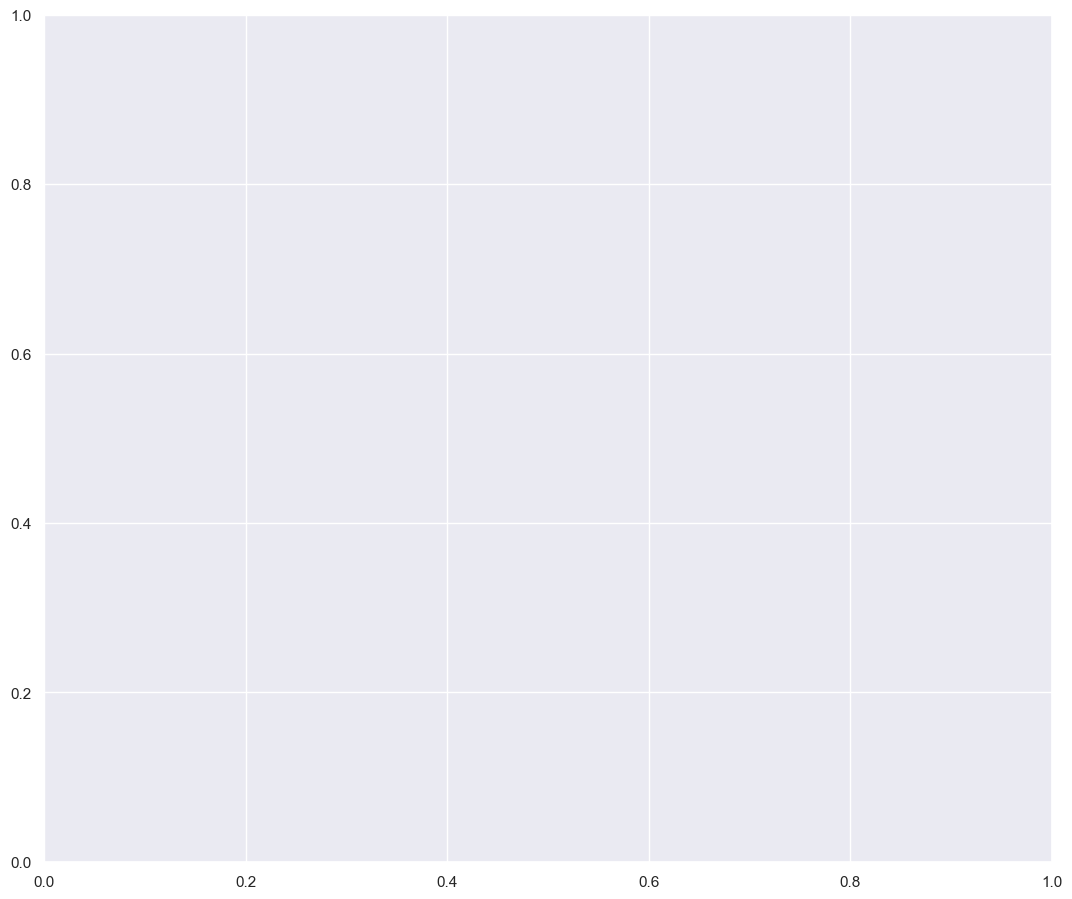

In [21]:
fig, ax = plt.subplots(figsize = (13,11))
sns.countplot(business_restaurant['stars'], ax=ax)
plt.title('Review plots for Restaurants in Business dataset')
plt.show()

[Text(0.5, 0, 'Restaurant'), Text(0, 0.5, 'Review Count')]

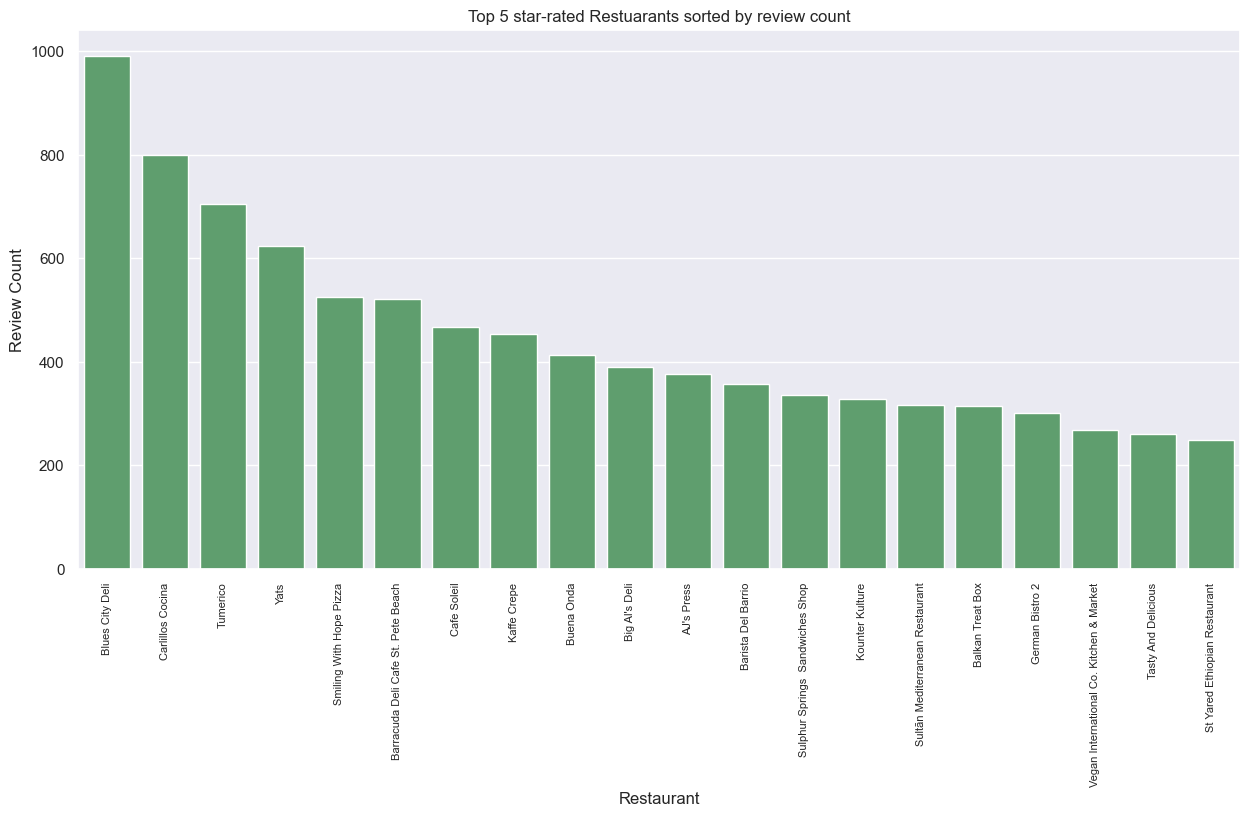

In [22]:
top_res = business_restaurant[business_restaurant["stars"]==5]
top_res = top_res.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='Restaurant name', y="review_count", data=top_res,color="g")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Top 5 star-rated Restuarants sorted by review count")
p.set(xlabel="Restaurant", ylabel="Review Count")

[Text(0.5, 0, 'Restaurant'), Text(0, 0.5, 'Review Count')]

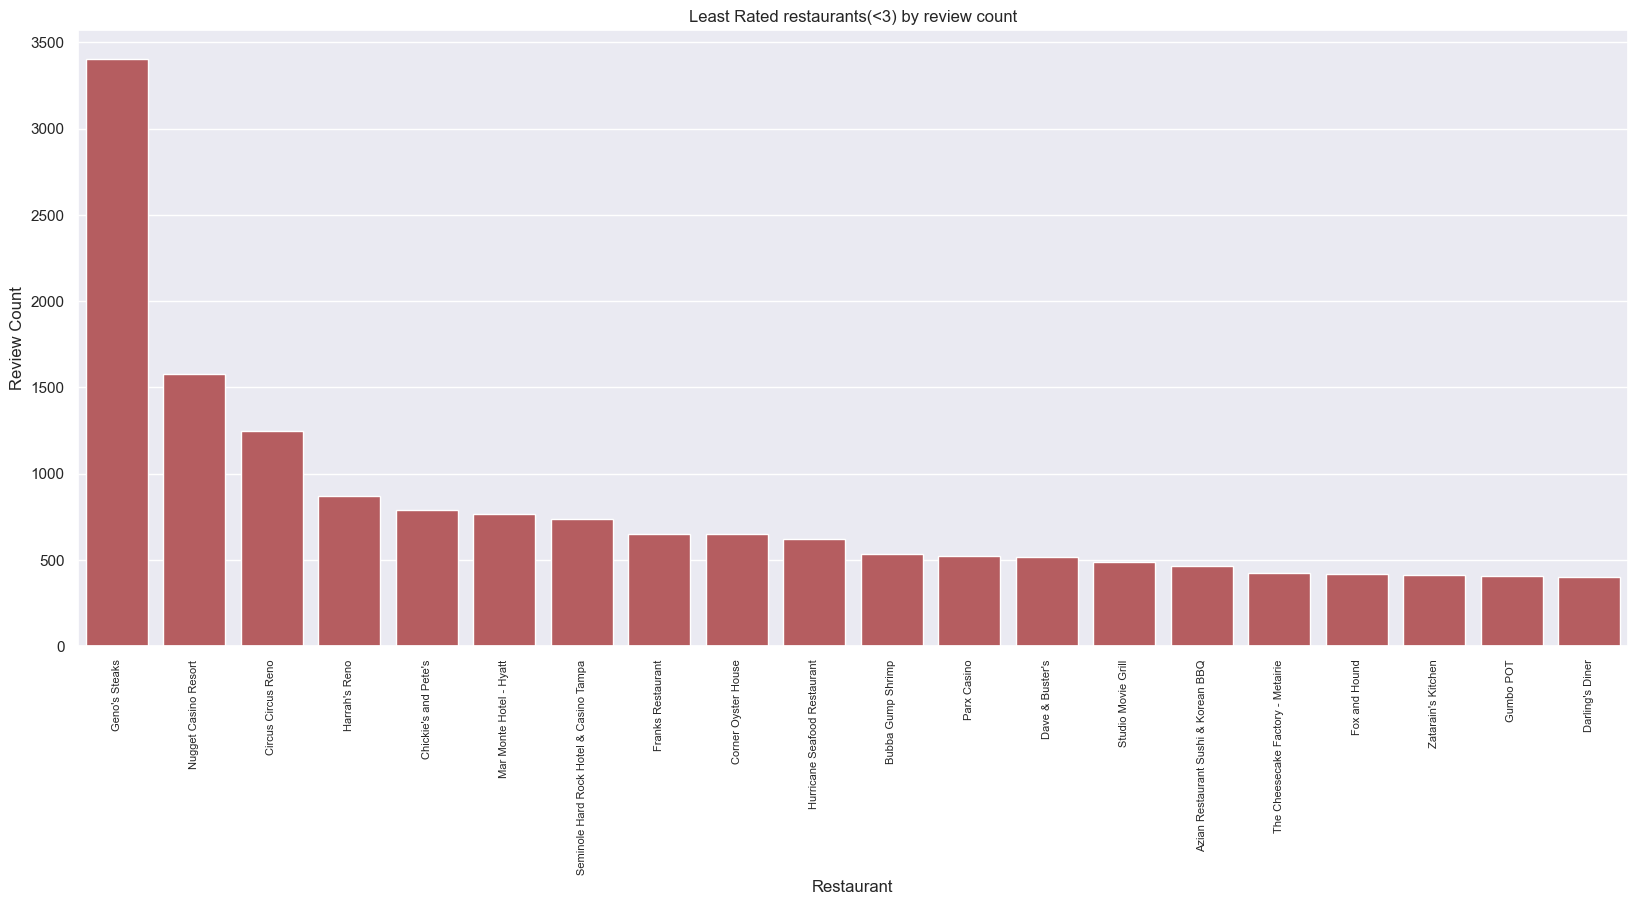

In [23]:
top_res = business_restaurant[business_restaurant["stars"]< 3]
top_res = top_res.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(20,8))
p = sns.barplot(x='Restaurant name', y="review_count", data=top_res,color="r")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Least Rated restaurants(<3) by review count")
p.set(xlabel="Restaurant", ylabel="Review Count")

In [24]:
#business_restaurant = business_restaurant[business_restaurant['business_id'].isin(review_data['business_id'])]


In [25]:
# Combine the columns from the given dataframe to consist only of required columns for model
ratings_data = review_data.join(business_restaurant.set_index('business_id'), on='business_id',  how='left', lsuffix='_review', rsuffix='_business')
ratings_data = ratings_data.join(user_data.set_index('user_id'), on = 'user_id', how='left', lsuffix='_left', rsuffix='_right')
ratings_data.head()

,review_id,user_id,business_id,stars_review,categories,review_count,Restaurant name,stars_business,Restaurants,Username
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"Restaurants, Breakfast & Brunch, Food, Juice B...",169.0,Turning Point of North Wales,3.0,True,Melanie
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,NaN,NaN,NaN,NaN,NaN,Erin
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,"Restaurants, Breakfast & Brunch",47.0,Kettle Restaurant,3.5,True,Debra
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Halal, Pakistani, Restaurants, Indian",181.0,Zaika,4.0,True,Kyle
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",32.0,Melt,4.0,True,Sophia


In [26]:
ratings_data_sample = ratings_data.head(1000)

In [27]:
ratings_data.shape

(6990280, 10)

In [28]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, business id and stars (in that order).
data = Dataset.load_from_df(ratings_data_sample[['user_id', 'business_id', 'stars_review']], reader)

# An antiset is a set of those user and item pairs for which a rating doesn't exist in original dataset
# We will use this data for testing
anti_set = data.build_full_trainset().build_anti_testset()
#trainset, testset = train_test_split(data, test_size=0.25)

In [29]:
print(data)

In [30]:
sim_options = { 'name': 'cosine' ,'user_based':  False}
kf = KFold(n_splits=5)
algo = KNNWithMeans(k =3 , sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3037
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3709
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3636
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4073
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4082


In [31]:
pred_df = pd.DataFrame(best_pred).merge(ratings_data_sample , left_on = ['uid', 'iid'], right_on = ['user_id', 'business_id'])
pred_df[['uid', 'iid',  'Username', 'user_id', 'Restaurant name', 'business_id', 'est','stars_review']]

,uid,iid,Username,user_id,Restaurant name,business_id,est,stars_review
0,hwKBB5PVOtD5KAfT_ucsYw,Uj2LpQ5Hni4kQPC-jt9JPA,Brian,hwKBB5PVOtD5KAfT_ucsYw,NaN,Uj2LpQ5Hni4kQPC-jt9JPA,3.81375,5.0
1,pqlLJVba9KAtahkjvNINYg,Dv6RfXLYe1atjgz3Xf4GGw,Caitlin,pqlLJVba9KAtahkjvNINYg,HipCityVeg,Dv6RfXLYe1atjgz3Xf4GGw,3.81375,4.0
2,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,Sandy,3inG_FUhm28tUJc0zZ2fCg,PizzaMan Dan's,aY_n9RSaD2Yw09jSFFePew,3.81375,1.0
3,oP3oYmqGyylvHxZR8ejGQg,72Y65Cg8MO1t9cWCHpwEQQ,David,oP3oYmqGyylvHxZR8ejGQg,Fresco Italian Sandwich Shoppe,72Y65Cg8MO1t9cWCHpwEQQ,3.81375,5.0
4,0nOrJJ4gN5BxYIyxWcJaGA,Mha77MN_BYGB-w7DONZ5YA,Chris,0nOrJJ4gN5BxYIyxWcJaGA,Cuenelli's Peruvian Restaurant,Mha77MN_BYGB-w7DONZ5YA,3.81375,5.0
...,...,...,...,...,...,...,...,...
195,SNngOVGTkD34B3FAFnMv5A,ab3pRv-b0o-BwMK2jVbH3Q,Janelle,SNngOVGTkD34B3FAFnMv5A,Saki Endless Sushi & Hibachi Eatery,ab3pRv-b0o-BwMK2jVbH3Q,3.81375,5.0
196,nyjj6EHn29se2IE8c_Wq4A,2K75poiMupFTvpQq5REWTA,Gabriela,nyjj6EHn29se2IE8c_Wq4A,NaN,2K75poiMupFTvpQq5REWTA,3.81375,5.0
197,EJqV61HlYmFEmzcIaRVVOw,tpSeNezanZDvsXWR7Hhi1w,Amy,EJqV61HlYmFEmzcIaRVVOw,Taco Bell,tpSeNezanZDvsXWR7Hhi1w,3.81375,1.0
198,nBUnQnecIYYWuxk0g5njhw,j99PtxlKTW_u5alE4jiqHQ,Leah,nBUnQnecIYYWuxk0g5njhw,Ralphs Italian Restaurant,j99PtxlKTW_u5alE4jiqHQ,3.81375,5.0


In [32]:
anti_pre = best_algo.test(anti_set)
pred_df = pd.DataFrame(anti_pre).merge(business_restaurant , left_on = ['iid'], right_on = ['business_id'])
pred_df = pd.DataFrame(pred_df).merge(user_data , left_on = ['uid'], right_on = ['user_id'])

In [33]:
pred_df[:1000]

,uid,iid,r_ui,est,details,business_id,categories,review_count,Restaurant name,stars,Restaurants,user_id,Username
0,mh_-eMZ6K5RLWhZyISBhwA,YjUWPpI6HXG530lwP-fb2A,3.85,3.00000,"{'actual_k': 0, 'was_impossible': False}",YjUWPpI6HXG530lwP-fb2A,"Restaurants, Breakfast & Brunch",47,Kettle Restaurant,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
1,mh_-eMZ6K5RLWhZyISBhwA,kxX2SOes4o-D3ZQBkiMRfA,3.85,4.00000,"{'actual_k': 0, 'was_impossible': False}",kxX2SOes4o-D3ZQBkiMRfA,"Halal, Pakistani, Restaurants, Indian",181,Zaika,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
2,mh_-eMZ6K5RLWhZyISBhwA,e4Vwtrqf-wpJfwesgvdgxQ,3.85,4.00000,"{'actual_k': 0, 'was_impossible': False}",e4Vwtrqf-wpJfwesgvdgxQ,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",32,Melt,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
3,mh_-eMZ6K5RLWhZyISBhwA,04UD14gamNjLY0IDYVhHJg,3.85,1.00000,"{'actual_k': 0, 'was_impossible': False}",04UD14gamNjLY0IDYVhHJg,"Mediterranean, Restaurants, Seafood, Greek",273,Dmitri's,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
4,mh_-eMZ6K5RLWhZyISBhwA,LHSTtnW3YHCeUkRDGyJOyw,3.85,3.86875,"{'was_impossible': True, 'reason': 'User and/o...",LHSTtnW3YHCeUkRDGyJOyw,"Beer Bar, Bars, American (New), Gastropubs, Re...",103,Fries Rebellion,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,OyoGAe7OKpv6SyGZT5g77Q,zVoxVPHEt11_0GzqNuT2ZQ,3.85,4.00000,"{'actual_k': 0, 'was_impossible': False}",zVoxVPHEt11_0GzqNuT2ZQ,"Restaurants, American (New)",186,Home Wine Kitchen,4.0,True,OyoGAe7OKpv6SyGZT5g77Q,Erin
996,OyoGAe7OKpv6SyGZT5g77Q,aZNiVR6oAMQX5__yGPvYsg,3.85,3.00000,"{'actual_k': 0, 'was_impossible': False}",aZNiVR6oAMQX5__yGPvYsg,"Chinese, Restaurants",26,Susanna Foo Chinese Cuisine,3.5,True,OyoGAe7OKpv6SyGZT5g77Q,Erin
997,OyoGAe7OKpv6SyGZT5g77Q,-K0zTgGyxo-AeSkcV0IVaA,3.85,5.00000,"{'actual_k': 0, 'was_impossible': False}",-K0zTgGyxo-AeSkcV0IVaA,"Mediterranean, Restaurants",158,Spiro's Restaurant,4.5,True,OyoGAe7OKpv6SyGZT5g77Q,Erin
998,OyoGAe7OKpv6SyGZT5g77Q,LT4A5jVMURvH_DKdr7A91w,3.85,1.00000,"{'actual_k': 0, 'was_impossible': False}",LT4A5jVMURvH_DKdr7A91w,"Sandwiches, Barbeque, Restaurants, Food",65,Big Q BBQ,2.5,True,OyoGAe7OKpv6SyGZT5g77Q,Erin


In [34]:
## Recommend a restaurant to the user if the estimated rating is equal to 5

pred_df[(pred_df['est'] == 5)&(pred_df['user_id']=='mh_-eMZ6K5RLWhZyISBhwA')]

,uid,iid,r_ui,est,details,business_id,categories,review_count,Restaurant name,stars,Restaurants,user_id,Username
13,mh_-eMZ6K5RLWhZyISBhwA,eFvzHawVJofxSnD7TgbZtg,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",eFvzHawVJofxSnD7TgbZtg,"Food, Cafes, Coffee & Tea, Restaurants",249,Good Karma Cafe,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
18,mh_-eMZ6K5RLWhZyISBhwA,x4XdNhp0Xn8lOivzc77J-g,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",x4XdNhp0Xn8lOivzc77J-g,"Thai, Restaurants",222,Thai Place Restaurant,4.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
20,mh_-eMZ6K5RLWhZyISBhwA,MWmXGQ98KbRo3vsS5nZhMA,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",MWmXGQ98KbRo3vsS5nZhMA,"Event Planning & Services, Italian, Venues & E...",32,Anthony's at Paxon Hollow,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
23,mh_-eMZ6K5RLWhZyISBhwA,bbEXAEFr4RYHLlZ-HFssTA,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",bbEXAEFr4RYHLlZ-HFssTA,"Fast Food, Burgers, Restaurants",329,The Original Habit Burger Grill,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
24,mh_-eMZ6K5RLWhZyISBhwA,0pMj5xUAecW9o1P35B0AMw,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",0pMj5xUAecW9o1P35B0AMw,"Food, Coffee & Tea, Gas Stations, Restaurants,...",8,Wawa,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,mh_-eMZ6K5RLWhZyISBhwA,F1xE--Gb4rNFAwHkNkV31A,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",F1xE--Gb4rNFAwHkNkV31A,"Pizza, Vegan, Restaurants, Beer, Wine & Spirit...",278,Eclipse Pizza Co.,4.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
548,mh_-eMZ6K5RLWhZyISBhwA,L-YdO_NODKXXT3bkS0nUpg,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",L-YdO_NODKXXT3bkS0nUpg,"American (Traditional), Restaurants, Bars, Sea...",664,RumFish Grill,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
549,mh_-eMZ6K5RLWhZyISBhwA,L7i_5DydYEKwPLfcDBRYDA,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",L7i_5DydYEKwPLfcDBRYDA,"Mexican, Fast Food, Restaurants",44,Chipotle Mexican Grill,2.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
551,mh_-eMZ6K5RLWhZyISBhwA,1_hDCN3iioFR3XnUr32ZtA,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",1_hDCN3iioFR3XnUr32ZtA,"Fast Food, Turkish, German, Greek, Mediterrane...",109,Dooners,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie


In [35]:
## get restaurants recommendations for given user

def get_recommendations(user_id, estimated_prediction):
    df_recommended = pred_df[(pred_df['est'] >= estimated_prediction) & (pred_df['user_id'] == user_id)]
    restaurants = df_recommended['Restaurant name']
    return restaurants

In [36]:
user_data.head(100)

,user_id,Username
0,qVc8ODYU5SZjKXVBgXdI7w,Walker
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel
2,2WnXYQFK0hXEoTxPtV2zvg,Steph
3,SZDeASXq7o05mMNLshsdIA,Gwen
4,hA5lMy-EnncsH4JoR-hFGQ,Karen
...,...,...
95,8m2LgacB5VeP_1Mn5ZMC4w,Alan
96,MvOXPiqRr9IjqVtwC5mUNA,Jessica
97,PrJ37Ik9DxritxGPqI9ktw,David
98,dHLL7SVGJw5uM6IEp_wb4Q,Constance


In [37]:
user = 'OyoGAe7OKpv6SyGZT5g77Q'
recommendations = get_recommendations(user, 5)

print('\n\nRecommendations are listed below for userid ', user)
print('\n Top 10 Recommended Restaurants')
print(recommendations[:10])




Recommendations are listed below for userid  OyoGAe7OKpv6SyGZT5g77Q

 Top 10 Recommended Restaurants
567                    Good Karma Cafe
572              Thai Place Restaurant
574          Anthony's at Paxon Hollow
577    The Original Habit Burger Grill
578                               Wawa
579               Helena Avenue Bakery
580                  The Coventry Deli
585              Three Brothers Coffee
593                   Chase's Hop Shop
599                         Just Pizza
Name: Restaurant name, dtype: object
